Fitting of MFX-confocal shift compensation for all the recorded shift files in multiple folders, data overlaid. Bidirectional or unidirectional scanning is handled.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import skimage.feature as ft
from scipy.optimize import curve_fit
from scipy import stats, signal

def gaussian2D(xy, amplitude, xo, yo, sigma, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def sinusoidal(x, a, x0, f, b, c):
    y = a*np.sin(2*np.pi*f*x+x0) + b - x/c
    return (y)

def secpol(x, a, b, c):
    y = a*x**2 + b*x + c
    return (y)

def linear(x, a, b):
    y = a*x + b
    return (y)

def distance(p_1, p_2):
    return np.sqrt((p_2[0]-p_1[0])**2+(p_2[1]-p_1[1])**2)

# manual parameters
d_th_um = 0.35  # distance threshold for being considered the same bead

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

['confocal-pxs100nm-dwell002us-rep0.tif', 'confocal-pxs100nm-dwell002us-rep2.tif', 'confocal-pxs100nm-dwell002us-rep3.tif', 'confocal-pxs100nm-dwell002us-rep4.tif', 'confocal-pxs100nm-dwell002us-rep5.tif', 'confocal-pxs100nm-dwell100us-rep0.tif']
confocal-pxs100nm-dwell002us-rep0.tif
Scan speed: 50.0 µm/ms
6.0
2108
confocal-pxs100nm-dwell002us-rep2.tif
Scan speed: 50.0 µm/ms
6.0
2087
confocal-pxs100nm-dwell002us-rep3.tif
Scan speed: 50.0 µm/ms
6.0
2080
confocal-pxs100nm-dwell002us-rep4.tif
Scan speed: 50.0 µm/ms
6.0
2073
confocal-pxs100nm-dwell002us-rep5.tif
Scan speed: 50.0 µm/ms
6.0
2088
confocal-pxs100nm-dwell100us-rep0.tif
Scan speed: 1.0 µm/ms
200.8
2059
1784
['confocal-pxs100nm-dwell002us-rep0.tif', 'confocal-pxs100nm-dwell002us-rep2.tif', 'confocal-pxs100nm-dwell002us-rep3.tif', 'confocal-pxs100nm-dwell002us-rep4.tif', 'confocal-pxs100nm-dwell002us-rep5.tif', 'confocal-pxs100nm-dwell100us-rep0.tif']
confocal-pxs100nm-dwell002us-rep0.tif
Scan speed: 50.0 µm/ms
6.24
1952
confocal-

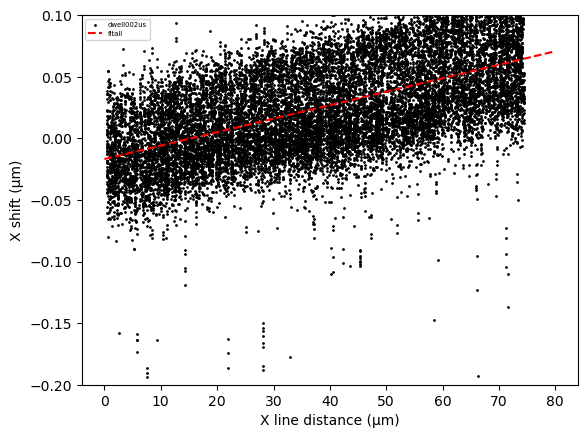

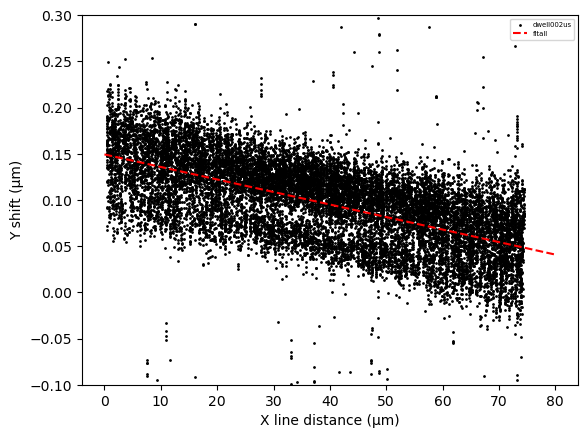

In [ ]:
### FIT ALL DATAPOINTS FROM MULTIPLE DATASETS IN ONE FIT - TOO GET THE BEST AVERAGE SHIFT THAT WE CAN CORRECT FOR, AS WE CANNOT KNOW WHICH IS THE "TRUE" SHIFT IT SEEMS LIKE
pxsize_info = 100.0

### 70 nm pxs
if pxsize_info == 70.0:
    folders = [os.path.join(parentdir, 'exampledata\\confshift\\pxs70fov10\\01'),
               os.path.join(parentdir, 'exampledata\\confshift\\pxs70fov10\\02')]
    savefolder = os.path.join(parentdir, 'exampledata\\confshift\\pxs70fov10')
    scanspeed = 35.0
### 100 nm pxs
if pxsize_info == 100.0:
    folders = [os.path.join(parentdir, 'exampledata\\confshift\\pxs100fov80bid\\01'),
               os.path.join(parentdir, 'exampledata\\confshift\\pxs100fov80bid\\02')]
    savefolder = os.path.join(parentdir, 'exampledata\\confshift\\pxs100fov80bid')
    scanspeed = 50.0

t_lim = 0.1

if 'bid' in folders[0]:
    x_shift_use_all = []
else:
    x1_use_all = []
    x1_shift_use_all = []
    x2_use_all = []
    x2_shift_use_all = []
x_all = []
x_shift_all = []

x_use_all = []
y_shift_all = []
y_shift_use_all = []

for folder in folders:
    filelist = os.listdir(folder)
    filelist_tif = [file for file in filelist if file.endswith('.tif')]
    print(filelist_tif)

    imgmini_size = 9
    base_comp_idx = len(filelist_tif)-1

    x_pks_corr_all = []
    y_pks_corr_all = []
    scanspeeds = []
    pxsizes = []
    pxsizesscaled = []
    dwelltimes = []
    for path_idx in range(len(filelist_tif)):
        print(filelist_tif[path_idx])
        pxsize = int(filelist_tif[path_idx].split('pxs')[1].split('nm')[0])/1000  # pixel size in µm
        dwelltime = int(filelist_tif[path_idx].split('dwell')[1].split('us')[0])/1000  # dwell time in ms
        if 'scaled' in filelist_tif[path_idx]:
            pxsscaled = int(filelist_tif[path_idx].split('scaled')[1].split('.')[0])/1000  # pixel size, scaled, in µm
        else:
            pxsscaled = pxsize
        pxsizesscaled.append(pxsscaled)
        pxsizes.append(pxsize)
        speed = pxsize/dwelltime  # scan speed in µm/ms
        scanspeeds.append(speed)
        dwelltimes.append(dwelltime)  # dwell time in ms
        print(f'Scan speed: {speed:.1f} µm/ms')
        img = tiff.imread(os.path.join(folder,filelist_tif[path_idx]))-32768
        img_max = np.max(img)
        pk_th_hi = img_max*0.6
        pk_th_lo = np.max([6,img_max*0.08])
        print(pk_th_lo)
        pks = ft.peak_local_max(img, min_distance=int(0.21/pxsscaled), threshold_abs=pk_th_lo)
        x_pks = pks[:,1]
        y_pks = pks[:,0]

        x_pks_filt = []
        y_pks_filt = []
        for pkx,pky in zip(x_pks[:],y_pks[:]):
            if img[pky,pkx] < pk_th_hi:
                x_pks_filt.append(pkx)
                y_pks_filt.append(pky)

        imgmini_rad = int((imgmini_size-1)/2)
        dxs = []
        dys = []

        for pkx,pky in zip(x_pks_filt,y_pks_filt):
            img_mini = img[pky-imgmini_rad:pky+imgmini_rad+1, pkx-imgmini_rad:pkx+imgmini_rad+1]
            # fit symmetric 2D gaussian
            x = np.linspace(0, imgmini_size-1, imgmini_size)
            y = np.linspace(0, imgmini_size-1, imgmini_size)
            x, y = np.meshgrid(x, y)
            try:
                initial_guess = (np.max(img_mini),imgmini_rad,imgmini_rad,1,0,10)
                popt, _ = curve_fit(gaussian2D, (x, y), img_mini.ravel(), p0=initial_guess)
                # get offsets from pixel-position
                dx = popt[1]-imgmini_rad
                dy = popt[2]-imgmini_rad
                dxs.append(dx)
                dys.append(dy)
            except:
                dxs.append(np.nan)
                dys.append(np.nan)
        x_pks_corr = [x_pk+dx for x_pk,dx in zip(x_pks_filt,dxs)]
        y_pks_corr = [y_pk+dx for y_pk,dx in zip(y_pks_filt,dys)]
        x_pks_corr_all.append(x_pks_corr)
        y_pks_corr_all.append(y_pks_corr)
        print(len(x_pks_corr))

    x_pks_base = x_pks_corr_all[base_comp_idx]
    y_pks_base = y_pks_corr_all[base_comp_idx]

    bead_links = [[] for _ in x_pks_base]  # each row has the bead indexes of the beads in each image which belongs together

    for idx_base, (x_pk,y_pk) in enumerate(zip(x_pks_base,y_pks_base)):
        for comp_idx in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
            d_th = int(d_th_um/pxsizesscaled[comp_idx])
            d_min = d_th
            idx_min = np.nan
            for idx_c, (x_pk_c, y_pk_c) in enumerate(zip(x_pks_corr_all[comp_idx],y_pks_corr_all[comp_idx])):
                d = distance((x_pk,y_pk),(x_pk_c,y_pk_c))
                if d < d_min:
                    d_min = d
                    idx_min = idx_c
                    bead_links[idx_base].append(idx_min)
                    break
            if d_min == d_th:
                bead_links[idx_base].append(np.nan)
        bead_links[idx_base].insert(base_comp_idx, idx_base)

    rm_idx = []
    for idx, link in enumerate(bead_links):
        if np.any(np.isnan(link)):
            rm_idx.append(idx)

    for index in sorted(rm_idx, reverse=True):
        del bead_links[index]
    print(len(bead_links))


    x_shifts = [[] for _ in x_pks_corr_all]
    x_pos = [[] for _ in x_pks_corr_all]
    for bead_ids in bead_links:
        x_shifts[base_comp_idx].append(0)
        for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
            x_shift = (x_pks_corr_all[base_comp_idx][bead_ids[base_comp_idx]] - x_pks_corr_all[img_id][bead_ids[img_id]])*pxsizesscaled[img_id]
            x_shifts[img_id].append(x_shift)
            x_pos[img_id].append(x_pks_corr_all[img_id][bead_ids[img_id]]*pxsizesscaled[img_id])

    y_shifts = [[] for _ in y_pks_corr_all]
    y_pos = [[] for _ in y_pks_corr_all]
    for bead_ids in bead_links:
        y_shifts[base_comp_idx].append(0)
        for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
            y_shift = (y_pks_corr_all[base_comp_idx][bead_ids[base_comp_idx]] - y_pks_corr_all[img_id][bead_ids[img_id]])*pxsizesscaled[img_id]
            y_shifts[img_id].append(y_shift)
            y_pos[img_id].append(y_pks_corr_all[img_id][bead_ids[img_id]]*pxsizesscaled[img_id])

    t_lim = 0.1
    img_ids = np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx)
    for img_id in img_ids:
        if img_id != base_comp_idx:
            x = np.array(x_pos[img_id])
            x_shift = np.array(x_shifts[img_id])
            y_shift = np.array(y_shifts[img_id])
            x_all.append(x)
            x_shift_all.append(x_shift)
            y_shift_all.append(y_shift)

            if 'bid' in folder:
                ### FITTING
                # FIT LIENAR FUNCTION
                # remove outliers
                x_shift_sm = signal.savgol_filter(x_shift, int(len(x_shift)/3), 3)
                zs = stats.zscore(x_shift_sm - x_shift)
                mask = np.abs(zs) < 2.3
                x_use = x[mask]
                x_shift_use = x_shift[mask]
                x_use_all.append(x_use)
                x_shift_use_all.append(x_shift_use)
                y_shift_use = y_shift[mask]
                y_shift_use_all.append(y_shift_use)
            else:
                ### X-FITTING
                # FIT MAIN SIGMOID
                # remove outliers
                x_shift_sm = signal.savgol_filter(x_shift, int(len(x_shift)/3), 3)
                zs = stats.zscore(x_shift_sm - x_shift)
                mask = np.abs(zs) < 2.3
                # remove points from initial ramping phase
                x_lim = scanspeeds[img_id]*t_lim
                mask[x < x_lim] = False
                x_use = x[mask]
                x_shift_use = x_shift[mask]
                x1_use_all.append(x_use)
                x1_shift_use_all.append(x_shift_use)
                
                # FIT INITIAL SECOND DEGREE POLYNOMIAL
                # remove outliers
                x_shift_sm = signal.savgol_filter(x_shift, int(len(x_shift)/3), 3)
                zs = stats.zscore(x_shift_sm - x_shift)
                mask = np.abs(zs) < 2.3
                # remove points from initial ramping phase
                x_lim = scanspeeds[img_id]*t_lim
                mask[x > x_lim] = False
                x_use = x[mask]
                x_shift_use = x_shift[mask]
                x2_use_all.append(x_use)
                x2_shift_use_all.append(x_shift_use)

                ### Y-FITTING
                # remove outliers
                y_shift_sm = signal.savgol_filter(y_shift, int(len(y_shift)/3), 3)
                zs = stats.zscore(y_shift_sm - y_shift)
                mask = np.abs(zs) < 2.3
                # remove points from initial ramping phase
                x_lim = scanspeeds[img_id]*t_lim
                mask[x < x_lim] = False
                x_use = x[mask]
                y_shift_use = y_shift[mask]
                x_use_all.append(x_use)
                y_shift_use_all.append(y_shift_use)       

x_fit = np.linspace(0, 80, 200)

if 'bid' in folder:
    x_shift_use_all = np.concatenate(x_shift_use_all).ravel()
else:
    x1_shift_use_all = np.concatenate(x1_shift_use_all).ravel()
    x2_shift_use_all = np.concatenate(x2_shift_use_all).ravel()
    x1_use_all = np.concatenate(x1_use_all).ravel()
    x2_use_all = np.concatenate(x2_use_all).ravel()
x_all = np.concatenate(x_all).ravel()
x_shift_all = np.concatenate(x_shift_all).ravel()
y_shift_all = np.concatenate(y_shift_all).ravel()
x_use_all = np.concatenate(x_use_all).ravel()
y_shift_use_all = np.concatenate(y_shift_use_all).ravel()

### X-FITTING
plt.figure()
plt.scatter(x_all, x_shift_all, s=1, color='k', label=filelist_tif[img_id].split('-')[2].split('.')[0])
if 'bid' in folder:
    # FIT LINEAR FUNCTION
    p0 = [1, 1]  # initial guess
    #bounds: a=slope, b=offset
    bounds = [(-10, -30), (10, 30)]
    popt, pcov = curve_fit(linear, x_use_all, x_shift_use_all, p0, bounds=bounds, method='dogbox', maxfev=3000)

    linfunc_fit = linear(x_fit, *popt)
    plt.plot(x_fit, linfunc_fit, 'r--', label='fitall')
    plt.ylim([-0.2,0.1])
else:
    x_lim = scanspeed*t_lim
    # FIT ENDING SIGMOID
    p0 = [(max(x1_shift_use_all)-min(x1_shift_use_all))/2, x_lim*2, 0.1, min(x1_shift_use_all)]  # initial guess
    #bounds: L=asymptote difference, x0=point of inflection, k=slope, b=low asymptote
    bounds = [(0, x_lim*0.5/3 if x_lim>0.4 else 0, 0, -0.3), (0.6, 20, 3, 0.1)]
    popt, pcov = curve_fit(sigmoid, x1_use_all, x1_shift_use_all, p0, bounds=bounds, method='trf', maxfev=5000)
    popt = np.append(popt,popt[-1]+popt[0])

    # FIT INITIAL SECOND DEGREE POLYNOMIAL
    p0 = [0.002, -0.02, -0.1]
    bounds = [(0.0001, -0.05, -0.15), (0.05, -0.005, -0.02)]
    popt2, pcov = curve_fit(secpol, x2_use_all, x2_shift_use_all, p0, bounds=bounds, method='trf', maxfev=5000)

    combfunc_fit = (1-sigmoid(x_fit, *[1,x_lim,1,0]))*secpol(x_fit, *popt2) + sigmoid(x_fit, *[1,x_lim,1,0])*sigmoid(x_fit, *popt[:-1])
    plt.plot(x_fit, combfunc_fit, 'r--', label='fitall')
    plt.ylim([-0.25,0.1])

plt.legend(prop={'size': 5})
plt.xlabel('X line distance (µm)')
plt.ylabel('X shift (µm)')

savename = 'multifitting-xshift'
if 'bid' in folders[0]:
    with open(os.path.join(savefolder,savename+'.txt'), 'w') as f:
        for line in popt:
            f.write(f"{line}\n")
else:
    with open(os.path.join(savefolder,savename+'.txt'), 'w') as f:
        for line in popt[:-1]:
            f.write(f"{line}\n")
        f.write('\n')
        for line in popt2:
            f.write(f"{line}\n")

plt.show()


### Y-FITTING
plt.figure()
plt.scatter(x_all, y_shift_all, s=1, color='k', label=filelist_tif[img_id].split('-')[2].split('.')[0])
if 'bid' in folder:
    p0 = [1, 1]  # initial guess
    #bounds: a=slope, b=offset
    bounds = [(-10, -30), (10, 30)]
    popt, pcov = curve_fit(linear, x_use_all, y_shift_use_all, p0, bounds=bounds, method='dogbox', maxfev=3000)

    linfunc_fit = linear(x_fit, *popt)
    plt.plot(x_fit, linfunc_fit, 'r--', label='fitall')

    plt.ylim([-0.1,0.3])
    plt.legend(prop={'size': 8})
    plt.xlabel('X line distance (µm)')
    plt.ylabel('Y shift (µm)')
else:
    # FIT MODIFIED SINE
    if pxsize_info == 70.0:
        p0 = [(max(y_shift_use_all)-min(y_shift_use_all))/4, 10, 0.8/(0.3*scanspeeds[img_id]), 0.02, 2000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
        bounds = [(-1, -20, 0.68/(0.3*scanspeeds[img_id]), 0.003, 500), ((max(y_shift_use_all)-min(y_shift_use_all))/2*5, 20, 0.9/(0.3*scanspeeds[img_id])*3, 0.06, 10000)]
    elif pxsize_info == 60.0:
        p0 = [(max(y_shift_use_all)-min(y_shift_use_all))/4, 0, 0.8/(0.3*scanspeeds[img_id]), (max(y_shift_use_all)-(max(y_shift_use_all)-min(y_shift_use_all))/2)+0.01, 4000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
        #bounds: a=amplitude, x0=phase, f=frequency (osc/µm), b=offset
        bounds = [((max(y_shift_use_all)-min(y_shift_use_all))/15, -10, 0.68/(0.3*scanspeeds[img_id]), -0.06, 0), ((max(y_shift_use_all)-min(y_shift_use_all))/2, 10, 0.9/(0.3*scanspeeds[img_id]), 0.06, 6000)]
    popt, pcov = curve_fit(sinusoidal, x_use_all, y_shift_use_all, p0, bounds=bounds, method='dogbox')
    shift_fit = sinusoidal(x_fit, *popt)
    plt.plot(x_fit, shift_fit, 'r--', label='fitall')
    plt.ylim([-0.2,0.2])

plt.legend(prop={'size': 5})
plt.xlabel('X line distance (µm)')
plt.ylabel('Y shift (µm)')
plt.show()

savename = 'multifitting-yshift'
with open(os.path.join(savefolder,savename+'.txt'), 'w') as f:
    for line in popt:
        f.write(f"{line}\n")